In [ ]:
# Check the column names in your dataset
data = pd.read_csv(filepath)
print(data.columns)


Index(['Dist Code', 'Year', 'State Code', 'State Name', 'Dist Name',
       'RICE YIELD (Kg per ha)', 'WHEAT YIELD (Kg per ha)',
       'KHARIF SORGHUM YIELD (Kg per ha)', 'RABI SORGHUM YIELD (Kg per ha)',
       'SORGHUM YIELD (Kg per ha)', 'PEARL MILLET YIELD (Kg per ha)',
       'MAIZE YIELD (Kg per ha)', 'FINGER MILLET YIELD (Kg per ha)',
       'BARLEY YIELD (Kg per ha)', 'CHICKPEA YIELD (Kg per ha)',
       'PIGEONPEA YIELD (Kg per ha)', 'MINOR PULSES YIELD (Kg per ha)',
       'GROUNDNUT YIELD (Kg per ha)', 'SESAMUM YIELD (Kg per ha)',
       'RAPESEED AND MUSTARD YIELD (Kg per ha)', 'SAFFLOWER YIELD (Kg per ha)',
       'CASTOR YIELD (Kg per ha)', 'LINSEED YIELD (Kg per ha)',
       'SUNFLOWER YIELD (Kg per ha)', 'SOYABEAN YIELD (Kg per ha)',
       'OILSEEDS YIELD (Kg per ha)', 'SUGARCANE YIELD (Kg per ha)',
       'COTTON YIELD (Kg per ha)'],
      dtype='object')


# Prophet by Facebook


In [ ]:
!pip install prophet


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Soil Health Categorization
def get_soil_category(score):
    if score == 0:
        return "No Soil Health Data"
    elif score >= 4.5:
        return "Very Excellent Soil Health"
    elif score >= 4:
        return "Excellent Soil Health"
    elif score >= 3:
        return "Good Soil Health"
    elif score >= 2:
        return "Poor Soil Health"
    else:
        return "Very Poor Soil Health"

# Climate Score Calculation
def calculate_climate_score(yield_cat, soil_cat):
    score_map = {
        # Yield Scores
        "Highly Recommended Crop": 90,
        "Good Crop": 70,
        "Poor Crop": 50,
        "Very Poor Crop": 30,

        # Soil Scores
        "Very Excellent Soil Health": 95,
        "Excellent Soil Health": 85,
        "Good Soil Health": 65,
        "Poor Soil Health": 45,
        "Very Poor Soil Health": 25,
        "No Soil Health Data": 0
    }
    return int((score_map[yield_cat] * 0.6) + (score_map[soil_cat] * 0.4))

def predict_crop_yield(yield_file, soil_file):
    # Load datasets
    yield_df = pd.read_csv(yield_file)
    soil_df = pd.read_csv(soil_file)

    # Process soil data
    soil_df['Soil_Category'] = soil_df['SoilHealthScore'].apply(get_soil_category)

    # Get exact column names from yield data
    yield_columns = [col for col in yield_df.columns if 'YIELD (Kg per ha)' in col]
    base_crop_names = {col.split(' YIELD')[0]: col for col in yield_columns}

    # User input
    print("\nAvailable crops:", ', '.join(base_crop_names.keys()))
    crop_input = input("\nEnter exact crop name: ").strip()
    district_input = input("Enter exact district name: ").strip()

    # Validate inputs
    if crop_input not in base_crop_names:
        print(f"\nError: '{crop_input}' not found in crops")
        return
    yield_col = base_crop_names[crop_input]

    # Validate district in yield data
    district_yield = yield_df[yield_df['Dist Name'] == district_input]
    if district_yield.empty:
        print(f"\nError: District '{district_input}' not found in yield data")
        return

    # Validate district in soil data
    district_soil = soil_df[soil_df['Dist Name'] == district_input]
    if district_soil.empty:
        print(f"\nError: District '{district_input}' not found in soil data")
        return

    # Prepare time series data
    ts_data = district_yield[['Year', yield_col]].dropna()
    ts_data.columns = ['ds', 'y']
    ts_data['ds'] = pd.to_datetime(ts_data['ds'], format='%Y')
    ts_data['year'] = ts_data['ds'].dt.year

    # 2017 Validation
    if 2017 in ts_data['year'].values:
        train = ts_data[ts_data['year'] < 2017]
        test = ts_data[ts_data['year'] == 2017]

        if len(train) >= 5 and not test.empty:
            # Train validation model
            model_val = Prophet(yearly_seasonality=True, growth='flat')
            model_val.fit(train)

            # Predict 2017
            future_val = model_val.make_future_dataframe(periods=1, freq='YS')
            forecast_val = model_val.predict(future_val)

            # Get prediction
            forecast_val['year'] = forecast_val['ds'].dt.year
            pred_2017 = forecast_val[forecast_val['year'] == 2017]

            if not pred_2017.empty:
                y_true = test['y'].values[0]
                y_pred = pred_2017['yhat'].values[0]

                # Calculate metrics
                mae = mean_absolute_error([y_true], [y_pred])
                mape = mean_absolute_percentage_error([y_true], [y_pred]) * 100

                # Print validation results
                print(f"\n{'='*40}")
                print(f"2017 Validation for {crop_input} in {district_input}")
                print(f"Actual Yield: {y_true:.2f} Kg/ha")
                print(f"Predicted Yield: {y_pred:.2f} Kg/ha")
                print(f"MAE: {mae:.2f} Kg/ha | MAPE: {mape:.2f}%")
                print(f"{'='*40}")

    # Full model training
    valid_data = ts_data[ts_data['y'] > 0]
    if len(valid_data) < 5:
        avg_yield = ts_data['y'].mean()
        print(f"\nPrediction for {crop_input} in {district_input}:")
        print(f"Insufficient data, using historical average: {avg_yield:.2f} Kg/ha")
        return

    model = Prophet(yearly_seasonality=True, growth='flat')
    model.fit(ts_data)

    # Future prediction
    future = model.make_future_dataframe(periods=1, freq='YS')
    forecast = model.predict(future)

    # Get latest prediction
    prediction = forecast.iloc[-1]
    predicted_yield = max(prediction['yhat'], 0)
    prediction_year = prediction['ds'].year

    # Yield categorization
    if predicted_yield > 1000:
        yield_cat = "Highly Recommended Crop"
    elif predicted_yield > 500:
        yield_cat = "Good Crop"
    elif predicted_yield > 200:
        yield_cat = "Poor Crop"
    else:
        yield_cat = "Very Poor Crop"

    # Get soil data
    soil_score = district_soil['SoilHealthScore'].values[0]
    soil_cat = district_soil['Soil_Category'].values[0]

    # Calculate climate score
    climate_score = calculate_climate_score(yield_cat, soil_cat)

    # Display results
    print(f"\n{'='*40}")
    print(f"Climate Analysis for {district_input}")
    print(f"Crop: {crop_input}")
    print(f"Predicted Yield: {predicted_yield:.2f} Kg/ha ({yield_cat})")
    print(f"Soil Health: {soil_cat} (Score: {soil_score})")
    print(f"Climate Score: {climate_score}/100")
    print(f"{'='*40}")

    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f'{crop_input} Yield Forecast\n{district_input}')
    plt.ylabel('Yield (Kg/ha)')
    plt.ylim(bottom=0)
    plt.show()

# Example usage
yield_file = '/content/drive/MyDrive/30_year_crop_data/ICRISAT-District_Level_Data_30_Years.csv'
soil_file = '/content/drive/MyDrive/GEE_Exports/SoilHealthScores_by_District_2.csv'
predict_crop_yield(yield_file, soil_file)


Available crops: RICE, WHEAT, KHARIF SORGHUM, RABI SORGHUM, SORGHUM, PEARL MILLET, MAIZE, FINGER MILLET, BARLEY, CHICKPEA, PIGEONPEA, MINOR PULSES, GROUNDNUT, SESAMUM, RAPESEED AND MUSTARD, SAFFLOWER, CASTOR, LINSEED, SUNFLOWER, SOYABEAN, OILSEEDS, SUGARCANE, COTTON

Enter exact crop name: RABI SORGHUM
Enter exact district name: Durg


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpurdg6yfz/_sg4fruu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpurdg6yfz/ocoou79e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58001', 'data', 'file=/tmp/tmpurdg6yfz/_sg4fruu.json', 'init=/tmp/tmpurdg6yfz/ocoou79e.json', 'output', 'file=/tmp/tmpurdg6yfz/prophet_model325ysyzk/prophet_model-20250222122438.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:


2017 Validation for RABI SORGHUM in Durg
Actual Yield: 0.00 Kg/ha
Predicted Yield: 144.61 Kg/ha
MAE: 144.61 Kg/ha | MAPE: 65125450705542512640.00%

Prediction for RABI SORGHUM in Durg:
Insufficient data, using historical average: 47.22 Kg/ha


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

def get_soil_category(score):
    if score == 0:
        return "No Soil Health Data"
    elif score >= 4.5:
        return "Very Excellent Soil Health"
    elif score >= 4:
        return "Excellent Soil Health"
    elif score >= 3:
        return "Good Soil Health"
    elif score >= 2:
        return "Poor Soil Health"
    else:
        return "Very Poor Soil Health"

def calculate_climate_score(yield_cat, soil_cat):
    score_map = {
        "Highly Recommended Crop": 90,
        "Good Crop": 70,
        "Poor Crop": 50,
        "Very Poor Crop": 30,
        "Very Excellent Soil Health": 95,
        "Excellent Soil Health": 85,
        "Good Soil Health": 65,
        "Poor Soil Health": 45,
        "Very Poor Soil Health": 25,
        "No Soil Health Data": 0
    }
    return int((score_map[yield_cat] * 0.6) + (score_map[soil_cat] * 0.4))

def predict_crop_yield(yield_file, soil_file):
    yield_df = pd.read_csv(yield_file)
    soil_df = pd.read_csv(soil_file)
    soil_df['Soil_Category'] = soil_df['SoilHealthScore'].apply(get_soil_category)

    yield_columns = [col for col in yield_df.columns if 'YIELD (Kg per ha)' in col]
    base_crop_names = {col.split(' YIELD')[0]: col for col in yield_columns}

    print("\nAvailable crops:", ', '.join(base_crop_names.keys()))
    crop_input = input("\nEnter exact crop name: ").strip()
    district_input = input("Enter exact district name: ").strip()

    if crop_input not in base_crop_names:
        print(f"\nError: '{crop_input}' not found in crops")
        return
    yield_col = base_crop_names[crop_input]

    # district
    district_yield = yield_df[yield_df['Dist Name'] == district_input]
    if district_yield.empty:
        print(f"\nError: District '{district_input}' not found in yield data")
        return

    district_soil = soil_df[soil_df['Dist Name'] == district_input]
    if district_soil.empty:
        print(f"\nError: District '{district_input}' not found in soil data")
        return

    # Time series data for selected crop
    ts_data = district_yield[['Year', yield_col]].dropna()
    ts_data.columns = ['ds', 'y']
    ts_data['ds'] = pd.to_datetime(ts_data['ds'], format='%Y')
    ts_data['year'] = ts_data['ds'].dt.year

    if 2017 in ts_data['year'].values:
        train = ts_data[ts_data['year'] < 2017]
        test = ts_data[ts_data['year'] == 2017]

        if len(train) >= 5 and not test.empty:
            model_val = Prophet(yearly_seasonality=True, growth='flat')
            model_val.fit(train)

            future_val = model_val.make_future_dataframe(periods=1, freq='YS')
            forecast_val = model_val.predict(future_val)

            forecast_val['year'] = forecast_val['ds'].dt.year
            pred_2017 = forecast_val[forecast_val['year'] == 2017]

            if not pred_2017.empty:
                y_true = test['y'].values[0]
                y_pred = pred_2017['yhat'].values[0]

                mae = mean_absolute_error([y_true], [y_pred])
                mape = mean_absolute_percentage_error([y_true], [y_pred]) * 100

                print(f"\n{'='*40}")
                print(f"2017 Validation for {crop_input} in {district_input}")
                print(f"Actual Yield: {y_true:.2f} Kg/ha")
                print(f"Predicted Yield: {y_pred:.2f} Kg/ha")
                print(f"MAE: {mae:.2f} Kg/ha | MAPE: {mape:.2f}%")
                print(f"{'='*40}")

    valid_data = ts_data[ts_data['y'] > 0]
    if len(valid_data) < 5:
        avg_yield = ts_data['y'].mean()
        print(f"\nPrediction for {crop_input} in {district_input}:")
        print(f"Insufficient data, using historical average: {avg_yield:.2f} Kg/ha")
    else:
        model = Prophet(yearly_seasonality=True, growth='flat')
        model.fit(ts_data)

        future = model.make_future_dataframe(periods=1, freq='YS')
        forecast = model.predict(future)

        prediction = forecast.iloc[-1]
        predicted_yield = max(prediction['yhat'], 0)

        if predicted_yield > 1000:
            yield_cat = "Highly Recommended Crop"
        elif predicted_yield > 500:
            yield_cat = "Good Crop"
        elif predicted_yield > 200:
            yield_cat = "Poor Crop"
        else:
            yield_cat = "Very Poor Crop"

        soil_score = district_soil['SoilHealthScore'].values[0]
        soil_cat = district_soil['Soil_Category'].values[0]
        climate_score = calculate_climate_score(yield_cat, soil_cat)

        print(f"\n{'='*40}")
        print(f"Climate Analysis for {district_input}")
        print(f"Crop: {crop_input}")
        print(f"Predicted Yield: {predicted_yield:.2f} Kg/ha ({yield_cat})")
        print(f"Soil Health: {soil_cat} (Score: {soil_score})")
        print(f"Climate Score: {climate_score}/100")
        print(f"{'='*40}")

    # Finding maximum yield for district
    best_crop = None
    max_yield = 0

    for crop, column in base_crop_names.items():
        ts_data = district_yield[['Year', column]].dropna()
        ts_data.columns = ['ds', 'y']
        ts_data['ds'] = pd.to_datetime(ts_data['ds'], format='%Y')

        if len(ts_data) >= 5:
            model = Prophet(yearly_seasonality=True, growth='flat')
            model.fit(ts_data)

            future = model.make_future_dataframe(periods=1, freq='YS')
            forecast = model.predict(future)

            predicted_yield = max(forecast.iloc[-1]['yhat'], 0)

            if predicted_yield > max_yield:
                max_yield = predicted_yield
                best_crop = crop

    if best_crop:
        print(f"\n{'='*40}")
        print(f"Maximum Yield Prediction for {district_input}:")
        print(f"Best Crop: {best_crop}")
        print(f"Predicted Yield: {max_yield:.2f} Kg/ha (Highly Recommended Crop)")
        print(f"{'='*40}")

yield_file = '/content/drive/MyDrive/30_year_crop_data/ICRISAT-District_Level_Data_30_Years.csv'
soil_file = '/content/drive/MyDrive/GEE_Exports/SoilHealthScores_by_District_2.csv'
predict_crop_yield(yield_file, soil_file)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/30_year_crop_data/ICRISAT-District_Level_Data_30_Years.csv'


Available crops: RICE, WHEAT, KHARIF SORGHUM, RABI SORGHUM, SORGHUM, PEARL MILLET, MAIZE, FINGER MILLET, BARLEY, CHICKPEA, PIGEONPEA, MINOR PULSES, GROUNDNUT, SESAMUM, RAPESEED AND MUSTARD, SAFFLOWER, CASTOR, LINSEED, SUNFLOWER, SOYABEAN, OILSEEDS, SUGARCANE, COTTON

Enter exact crop name:  RABI SORGHUM
Enter exact district name: Durg


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpurdg6yfz/7rrbbek8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpurdg6yfz/15ohbci0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41551', 'data', 'file=/tmp/tmpurdg6yfz/7rrbbek8.json', 'init=/tmp/tmpurdg6yfz/15ohbci0.json', 'output', 'file=/tmp/tmpurdg6yfz/prophet_modelgzx9xuiu/prophet_model-20250222135556.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:55:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:


2017 Validation for RABI SORGHUM in Durg
Actual Yield: 0.00 Kg/ha
Predicted Yield: 144.61 Kg/ha
MAE: 144.61 Kg/ha | MAPE: 65125450705542512640.00%

Prediction for RABI SORGHUM in Durg:
Insufficient data, using historical average: 47.22 Kg/ha


13:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpurdg6yfz/xogat4az.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpurdg6yfz/atv_rrh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32831', 'data', 'file=/tmp/tmpurdg6yfz/xogat4az.json', 'init=/tmp/tmpurdg6yfz/atv_rrh1.json', 'output', 'file=/tmp/tmpurdg6yfz/prophet_modeleqy_uwsc/prophet_model-20250222135557.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:55:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:c


Maximum Yield Prediction for Durg:
Best Crop: GROUNDNUT
Predicted Yield: 1354.82 Kg/ha (Highly Recommended Crop)


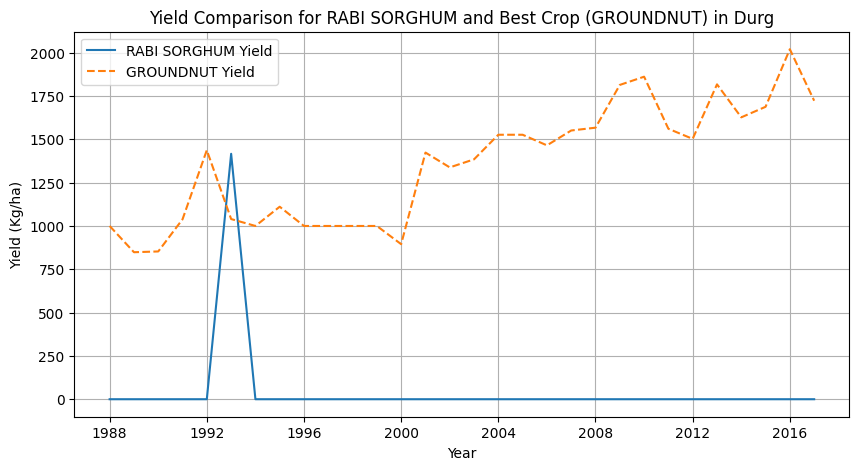


Best crop for the district: GROUNDNUT


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

def get_soil_category(score):
    if score == 0:
        return "No Soil Health Data"
    elif score >= 4.5:
        return "Very Excellent Soil Health"
    elif score >= 4:
        return "Excellent Soil Health"
    elif score >= 3:
        return "Good Soil Health"
    elif score >= 2:
        return "Poor Soil Health"
    else:
        return "Very Poor Soil Health"

def calculate_climate_score(yield_cat, soil_cat):
    score_map = {
        "Highly Recommended Crop": 90,
        "Good Crop": 70,
        "Poor Crop": 50,
        "Very Poor Crop": 30,
        "Very Excellent Soil Health": 95,
        "Excellent Soil Health": 85,
        "Good Soil Health": 65,
        "Poor Soil Health": 45,
        "Very Poor Soil Health": 25,
        "No Soil Health Data": 0
    }
    return int((score_map[yield_cat] * 0.6) + (score_map[soil_cat] * 0.4))

def predict_crop_yield(yield_file, soil_file):
    yield_df = pd.read_csv(yield_file)
    soil_df = pd.read_csv(soil_file)
    soil_df['Soil_Category'] = soil_df['SoilHealthScore'].apply(get_soil_category)

    yield_columns = [col for col in yield_df.columns if 'YIELD (Kg per ha)' in col]
    base_crop_names = {col.split(' YIELD')[0]: col for col in yield_columns}

    print("\nAvailable crops:", ', '.join(base_crop_names.keys()))
    crop_input = input("\nEnter exact crop name: ").strip()
    district_input = input("Enter exact district name: ").strip()

    if crop_input not in base_crop_names:
        print(f"\nError: '{crop_input}' not found in crops")
        return
    yield_col = base_crop_names[crop_input]

    # district
    district_yield = yield_df[yield_df['Dist Name'] == district_input]
    if district_yield.empty:
        print(f"\nError: District '{district_input}' not found in yield data")
        return

    district_soil = soil_df[soil_df['Dist Name'] == district_input]
    if district_soil.empty:
        print(f"\nError: District '{district_input}' not found in soil data")
        return

    # Time series data for selected crop
    ts_data = district_yield[['Year', yield_col]].dropna()
    ts_data.columns = ['ds', 'y']
    ts_data['ds'] = pd.to_datetime(ts_data['ds'], format='%Y')
    ts_data['year'] = ts_data['ds'].dt.year

    if 2017 in ts_data['year'].values:
        train = ts_data[ts_data['year'] < 2017]
        test = ts_data[ts_data['year'] == 2017]

        if len(train) >= 5 and not test.empty:
            model_val = Prophet(yearly_seasonality=True, growth='flat')
            model_val.fit(train)

            future_val = model_val.make_future_dataframe(periods=1, freq='YS')
            forecast_val = model_val.predict(future_val)

            forecast_val['year'] = forecast_val['ds'].dt.year
            pred_2017 = forecast_val[forecast_val['year'] == 2017]

            if not pred_2017.empty:
                y_true = test['y'].values[0]
                y_pred = pred_2017['yhat'].values[0]

                mae = mean_absolute_error([y_true], [y_pred])
                mape = mean_absolute_percentage_error([y_true], [y_pred]) * 100

                print(f"\n{'='*40}")
                print(f"2017 Validation for {crop_input} in {district_input}")
                print(f"Actual Yield: {y_true:.2f} Kg/ha")
                print(f"Predicted Yield: {y_pred:.2f} Kg/ha")
                print(f"MAE: {mae:.2f} Kg/ha | MAPE: {mape:.2f}%")
                print(f"{'='*40}")

    valid_data = ts_data[ts_data['y'] > 0]
    if len(valid_data) < 5:
        avg_yield = ts_data['y'].mean()
        print(f"\nPrediction for {crop_input} in {district_input}:")
        print(f"Insufficient data, using historical average: {avg_yield:.2f} Kg/ha")
    else:
        model = Prophet(yearly_seasonality=True, growth='flat')
        model.fit(ts_data)

        future = model.make_future_dataframe(periods=1, freq='YS')
        forecast = model.predict(future)

        prediction = forecast.iloc[-1]
        predicted_yield = max(prediction['yhat'], 0)

        if predicted_yield > 1000:
            yield_cat = "Highly Recommended Crop"
        elif predicted_yield > 500:
            yield_cat = "Good Crop"
        elif predicted_yield > 200:
            yield_cat = "Poor Crop"
        else:
            yield_cat = "Very Poor Crop"

        soil_score = district_soil['SoilHealthScore'].values[0]
        soil_cat = district_soil['Soil_Category'].values[0]
        climate_score = calculate_climate_score(yield_cat, soil_cat)

        print(f"\n{'='*40}")
        print(f"Climate Analysis for {district_input}")
        print(f"Crop: {crop_input}")
        print(f"Predicted Yield: {predicted_yield:.2f} Kg/ha ({yield_cat})")
        print(f"Soil Health: {soil_cat} (Score: {soil_score})")
        print(f"Climate Score: {climate_score}/100")
        print(f"{'='*40}")

    # Finding maximum yield for district
    best_crop = None
    max_yield = 0

    for crop, column in base_crop_names.items():
        ts_data = district_yield[['Year', column]].dropna()
        ts_data.columns = ['ds', 'y']
        ts_data['ds'] = pd.to_datetime(ts_data['ds'], format='%Y')

        if len(ts_data) >= 5:
            model = Prophet(yearly_seasonality=True, growth='flat')
            model.fit(ts_data)

            future = model.make_future_dataframe(periods=1, freq='YS')
            forecast = model.predict(future)

            predicted_yield = max(forecast.iloc[-1]['yhat'], 0)

            if predicted_yield > max_yield:
                max_yield = predicted_yield
                best_crop = crop

    maximum_crop = best_crop
    if maximum_crop:
        print(f"\n{'='*40}")
        print(f"Maximum Yield Prediction for {district_input}:")
        print(f"Best Crop: {best_crop}")
        print(f"Predicted Yield: {max_yield:.2f} Kg/ha (Highly Recommended Crop)")
        print(f"{'='*40}")

    plt.figure(figsize=(10, 5))
    ts_data = district_yield[['Year', yield_col]].dropna()
    ts_data.columns = ['ds', 'y']
    ts_data['ds'] = pd.to_datetime(ts_data['ds'], format='%Y')
    plt.plot(ts_data['ds'], ts_data['y'], label=f'{crop_input} Yield')

    best_crop_data = district_yield[['Year', base_crop_names[best_crop]]].dropna()
    best_crop_data.columns = ['ds', 'y']
    best_crop_data['ds'] = pd.to_datetime(best_crop_data['ds'], format='%Y')
    plt.plot(best_crop_data['ds'], best_crop_data['y'], label=f'{best_crop} Yield', linestyle='--')

    plt.xlabel('Year')
    plt.ylabel('Yield (Kg/ha)')
    plt.title(f"Yield Comparison for {crop_input} and Best Crop ({best_crop}) in {district_input}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return maximum_crop

yield_file = '/content/drive/MyDrive/30_year_crop_data/ICRISAT-District_Level_Data_30_Years.csv'
soil_file = '/content/drive/MyDrive/GEE_Exports/SoilHealthScores_by_District_2.csv'
maximum_crop = predict_crop_yield(yield_file, soil_file)
print(f"\nBest crop for the district: {maximum_crop}")
